In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from gensim.models import Word2Vec
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils.rnn as rnn_utils

In [2]:
# Load data
spacy_df = pd.read_csv('data/features_nltk.csv')
spacy_df = spacy_df[['headline', 'headline_cleaned', 'tokenized_text_nltk', 'lemmatized_text_nltk', 'is_sarcastic']]

# Process text columns
spacy_df['tokenized_text_nltk'] = spacy_df['tokenized_text_nltk'].apply(lambda x: x.replace('[','').replace(']','').replace("'",'').replace(",",'').split())
spacy_df['lemmatized_text_nltk'] = spacy_df['lemmatized_text_nltk'].apply(lambda x: x.replace('[','').replace(']','').replace("'",'').replace(",",'').split())

tokenized_sentences = spacy_df['tokenized_text_nltk'].tolist()
lemmatized_sentences = spacy_df['lemmatized_text_nltk'].tolist()
spacy_df.head()

,headline,headline_cleaned,tokenized_text_nltk,lemmatized_text_nltk,is_sarcastic
0,former versace store clerk sues over secret 'b...,former versace store clerk sues over secret bl...,"[former, versace, store, clerk, sues, over, se...","[former, versace, store, clerk, sue, secret, b...",0
1,the 'roseanne' revival catches up to our thorn...,the roseanne revival catches up to our thorny ...,"[the, roseanne, revival, catches, up, to, our,...","[roseanne, revival, catch, thorny, political, ...",0
2,mom starting to fear son's web series closest ...,mom starting to fear sons web series closest t...,"[mom, starting, to, fear, sons, web, series, c...","[mom, starting, fear, son, web, series, closes...",1
3,"boehner just wants wife to listen, not come up...",boehner just wants wife to listen not come up ...,"[boehner, just, wants, wife, to, listen, not, ...","[boehner, just, want, wife, listen, not, come,...",1
4,j.k. rowling wishes snape happy birthday in th...,jk rowling wishes snape happy birthday in the ...,"[jk, rowling, wishes, snape, happy, birthday, ...","[jk, rowling, wish, snape, happy, birthday, mo...",0


In [3]:
# Sentence length analysis
sentence_lengths = spacy_df['tokenized_text_nltk'].apply(len)
print("Max sentence length without lemmatization:", sentence_lengths.max())
print("Min sentence length without lemmatization:", sentence_lengths.min())
print("Mean sentence length without lemmatization:", sentence_lengths.mean())

sentence_lengths_lemmatized = spacy_df['lemmatized_text_nltk'].apply(len)
print("Max sentence length with lemmatization:", sentence_lengths_lemmatized.max())
print("Min sentence length with lemmatization:", sentence_lengths_lemmatized.min())
print("Mean sentence length with lemmatization:", sentence_lengths_lemmatized.mean())

Max sentence length without lemmatization: 39
Min sentence length without lemmatization: 2
Mean sentence length without lemmatization: 9.92627953124415
Max sentence length with lemmatization: 27
Min sentence length with lemmatization: 1
Mean sentence length with lemmatization: 7.223482721180127


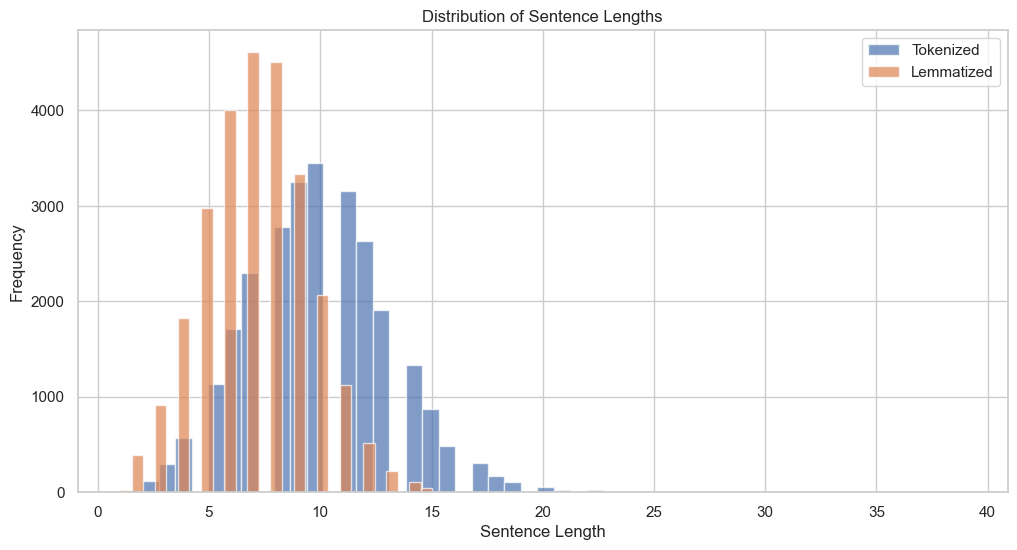

In [4]:
# Plot the distribution of sentence lengths
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
plt.hist(sentence_lengths, bins=50, alpha=0.7, label='Tokenized')
plt.hist(sentence_lengths_lemmatized, bins=50, alpha=0.7, label='Lemmatized')
plt.title('Distribution of Sentence Lengths')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

From the above, it can be seen that removing stopwords and lemmatizing reduces the spread of sentence lengths. Hence the RNN will work on the lemmatized texts for better standardization.

In [5]:
# Use lemmatized sentences to generate word2vec embeddings
model = Word2Vec(sentences=lemmatized_sentences, vector_size=100, window=5, min_count=1, workers=4)


We shall standardize the sentence length to 9. Any sentence longer than 9 words will be truncated to the first 9 words and any text less than that will be padded with zeroes

In [24]:
import numpy as np
import torch

# Function to get Word2Vec embeddings for a sentence
def get_word2vec_embeddings(model, sentence, embed_dim=100, sentence_length=9):
    embeddings = []

    for word in sentence:
        if word in model.wv:
            vec = model.wv[word]
            vec = vec / (np.linalg.norm(vec) + 1e-6)  # Normalize
            embeddings.append(vec)

    # Ensure exactly sentence_length words
    if len(embeddings) < sentence_length:
        # Pad with zeros
        embeddings += [np.zeros(embed_dim)] * (sentence_length - len(embeddings))
    else:
        # Truncate if too long
        embeddings = embeddings[:sentence_length]

    return torch.tensor(embeddings, dtype=torch.float32)  # Shape: (sentence_length, embed_dim)


In [25]:
# Convert text to word2vec embeddings
spacy_df['word2vec_embeddings'] = spacy_df['lemmatized_text_nltk'].apply(
    lambda x: get_word2vec_embeddings(model, x, embed_dim=100, sentence_length=9)
)

# Ensure labels are tensors
spacy_df['is_sarcastic'] = spacy_df['is_sarcastic'].apply(lambda x: torch.tensor(x, dtype=torch.float32))

spacy_df['embedding_len'] = spacy_df['word2vec_embeddings'].apply(lambda x: len(x))
# Check the embedding length
print(spacy_df['embedding_len'].unique())

[9]


C:\Users\Vaishnav M\AppData\Local\Temp\ipykernel_19232\4176788209.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  spacy_df['is_sarcastic'] = spacy_df['is_sarcastic'].apply(lambda x: torch.tensor(x, dtype=torch.float32))


In [26]:
# Train-test split
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(
    list(spacy_df['word2vec_embeddings']), list(spacy_df['is_sarcastic']),
    test_size=0.2, random_state=42
)

# Convert to tensors and create dataset
train_X = torch.stack(train_X)  # Now all should be (9, 100)
train_y = torch.stack(train_y)
test_X = torch.stack(test_X)
test_y = torch.stack(test_y)

# Create DataLoaders
from torch.utils.data import DataLoader, TensorDataset

batch_size = 32
train_dataset = TensorDataset(train_X, train_y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(test_X, test_y)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [27]:
train_X[4].shape

torch.Size([9, 100])

In [29]:
test_X[0].shape

torch.Size([9, 100])

In [30]:
# Implement the RNN model
import torch.nn as nn
class UniRNN(nn.Module):
    # Since we have already computed embeddings, we can directly use them as input to the RNN
    # The input size will be the embedding size (100 in this case)
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=1):
        super(UniRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, embeddings):
        # Pass the embeddings through the RNN
        rnn_out, _ = self.rnn(embeddings)
        # Use the last output of the RNN for classification
        last_out = rnn_out[:, -1, :]
        out = self.fc(last_out)
        out = self.sigmoid(out)
        return out

In [31]:
output_size = 1  # Binary classification (sarcastic or not sarcastic)
input_size = 100  # Embedding size
hidden_size = 50  # Size of the hidden layer
num_layers = 1  # Number of RNN layers

uni_rnn = UniRNN(input_size, hidden_size, output_size, num_layers)
# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(uni_rnn.parameters(), lr=0.001)

In [32]:
epochs = 5 # Number of epochs for training

# Training loop
for epoch in range(epochs):
    uni_rnn.train()
    for i, (embeddings, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = uni_rnn(embeddings)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

Epoch [1/5], Step [100/668], Loss: 0.6881
Epoch [1/5], Step [200/668], Loss: 0.6985
Epoch [1/5], Step [300/668], Loss: 0.6703
Epoch [1/5], Step [400/668], Loss: 0.7076
Epoch [1/5], Step [500/668], Loss: 0.6797
Epoch [1/5], Step [600/668], Loss: 0.7043
Epoch [2/5], Step [100/668], Loss: 0.7138
Epoch [2/5], Step [200/668], Loss: 0.6952
Epoch [2/5], Step [300/668], Loss: 0.6960
Epoch [2/5], Step [400/668], Loss: 0.6778
Epoch [2/5], Step [500/668], Loss: 0.6569
Epoch [2/5], Step [600/668], Loss: 0.7003
Epoch [3/5], Step [100/668], Loss: 0.6960
Epoch [3/5], Step [200/668], Loss: 0.7129
Epoch [3/5], Step [300/668], Loss: 0.6820
Epoch [3/5], Step [400/668], Loss: 0.6820
Epoch [3/5], Step [500/668], Loss: 0.7556
Epoch [3/5], Step [600/668], Loss: 0.6999
Epoch [4/5], Step [100/668], Loss: 0.6197
Epoch [4/5], Step [200/668], Loss: 0.5715
Epoch [4/5], Step [300/668], Loss: 0.7895
Epoch [4/5], Step [400/668], Loss: 0.7306
Epoch [4/5], Step [500/668], Loss: 0.6027
Epoch [4/5], Step [600/668], Loss:

In [22]:
train_X[0].shape

torch.Size([10, 100])

In [23]:
train_X[12].shape

torch.Size([9, 100])

In [33]:
# Evaluate test set
uni_rnn.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for embeddings, labels in test_loader:
        outputs = uni_rnn(embeddings)
        predicted = (outputs.squeeze() > 0.5).float()
        predictions.extend(predicted.numpy())
        true_labels.extend(labels.numpy())

# Convert to numpy arrays for classification report
predictions = np.array(predictions)
true_labels = np.array(true_labels)
# Classification report
print(classification_report(true_labels, predictions, target_names=['Not Sarcastic', 'Sarcastic']))

               precision    recall  f1-score   support

Not Sarcastic       0.62      0.84      0.71      2996
    Sarcastic       0.63      0.34      0.44      2346

     accuracy                           0.62      5342
    macro avg       0.62      0.59      0.58      5342
 weighted avg       0.62      0.62      0.59      5342



### Bidirectional RNN

In [40]:
class BiRNN(nn.Module):
    # Since we have already computed embeddings, we can directly use them as input to the RNN
    # The input size will be the embedding size (100 in this case)
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=1):
        super(BiRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.bidirectional = True
        self.fc = nn.Linear(hidden_size * 2, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, embeddings):
        # Pass the embeddings through the RNN
        rnn_out, _ = self.rnn(embeddings)
        # Use the last output of the RNN for classification
        last_out = rnn_out[:, -1, :]
        out = self.fc(last_out)
        out = self.sigmoid(out)
        return out
        
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        return torch.zeros(self.num_layers * 2, batch_size, self.hidden_size)  # Multiply by 2 for bidirectionality

In [41]:
# Initialize BiRNN model
bi_rnn = BiRNN(input_size, hidden_size, output_size, num_layers)
# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(bi_rnn.parameters(), lr=0.001)

In [42]:
# Training loop for BiRNN
for epoch in range(epochs):
    bi_rnn.train()
    for i, (embeddings, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = bi_rnn(embeddings)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

Epoch [1/5], Step [100/668], Loss: 0.6702
Epoch [1/5], Step [200/668], Loss: 0.6810
Epoch [1/5], Step [300/668], Loss: 0.6541
Epoch [1/5], Step [400/668], Loss: 0.6802
Epoch [1/5], Step [500/668], Loss: 0.6762
Epoch [1/5], Step [600/668], Loss: 0.7258
Epoch [2/5], Step [100/668], Loss: 0.6934
Epoch [2/5], Step [200/668], Loss: 0.6577
Epoch [2/5], Step [300/668], Loss: 0.6390
Epoch [2/5], Step [400/668], Loss: 0.7278
Epoch [2/5], Step [500/668], Loss: 0.6848
Epoch [2/5], Step [600/668], Loss: 0.6823
Epoch [3/5], Step [100/668], Loss: 0.7175
Epoch [3/5], Step [200/668], Loss: 0.5770
Epoch [3/5], Step [300/668], Loss: 0.6821
Epoch [3/5], Step [400/668], Loss: 0.7469
Epoch [3/5], Step [500/668], Loss: 0.6649
Epoch [3/5], Step [600/668], Loss: 0.7148
Epoch [4/5], Step [100/668], Loss: 0.6538
Epoch [4/5], Step [200/668], Loss: 0.5831
Epoch [4/5], Step [300/668], Loss: 0.5870
Epoch [4/5], Step [400/668], Loss: 0.6984
Epoch [4/5], Step [500/668], Loss: 0.5616
Epoch [4/5], Step [600/668], Loss:

In [43]:
# Evaluate test set for BiRNN
bi_rnn.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for embeddings, labels in test_loader:
        outputs = bi_rnn(embeddings)
        predicted = (outputs.squeeze() > 0.5).float()
        predictions.extend(predicted.numpy())
        true_labels.extend(labels.numpy())

# Classification report for BiRNN
print(classification_report(true_labels, predictions, target_names=['Not Sarcastic', 'Sarcastic']))

               precision    recall  f1-score   support

Not Sarcastic       0.68      0.59      0.63      2996
    Sarcastic       0.55      0.64      0.59      2346

     accuracy                           0.61      5342
    macro avg       0.61      0.61      0.61      5342
 weighted avg       0.62      0.61      0.61      5342

